In [1]:
import requests, json, time, re
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

In [2]:
reddit = pd.read_csv('./datasets/reddit_3.csv')

In [3]:
reddit.head()

,text,is_news
0,Scientist Stephen Hawking has died aged 76,1
1,F.C.C. Announces Plan to Repeal Net Neutrality,1
2,Report: Stan Lee dead at 95 - Story,1
3,Arizona Senator John McCain has passed away at...,1
4,"Apple admits it slows older iPhones, confirmin...",1


In [4]:
reddit['text'] = reddit.text.map(lambda x: re.sub('\s[\/]?r\/[^s]+', ' ', x))
reddit['text'] = reddit.text.map(lambda x: re.sub('http[s]?:\/\/[^\s]*', ' ', x))
reddit['text'] = reddit.text.map(lambda x: re.sub('(news:|news)[s]?', ' ', x, flags=re.I))

In [5]:
reddit.head()

,text,is_news
0,Scientist Stephen Hawking has died aged 76,1
1,F.C.C. Announces Plan to Repeal Net Neutrality,1
2,Report: Stan Lee dead at 95 - Story,1
3,Arizona Senator John McCain has passed away at...,1
4,"Apple admits it slows older iPhones, confirmin...",1


In [6]:
X = reddit.drop('is_news', axis=1)
y = reddit['is_news']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=24)

In [8]:
tfidf = TfidfVectorizer(stop_words='english', max_df=.95, min_df=5)

In [9]:
train_raw = tfidf.fit_transform(X_train['text'])

In [10]:
train_raw

<2151x875 sparse matrix of type '<class 'numpy.float64'>'
	with 9218 stored elements in Compressed Sparse Row format>

In [11]:
train_df = pd.SparseDataFrame(train_raw, columns=tfidf.get_feature_names())

train_df.head(10)

,000,10,100,11,12,13,15,16,17,18,...,worth,wrong,year,years,york,young,youtube,zealand,zone,zoo
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,0.576157,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.389896,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.271629,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
train_df.fillna(0, inplace=True)

In [13]:
train_df.isnull().sum().sum()

0

In [14]:
test_raw = tfidf.transform(X_test['text'])
test_df = pd.SparseDataFrame(test_raw, columns=tfidf.get_feature_names())
test_df.fillna(0, inplace=True)
test_df.head()

,000,10,100,11,12,13,15,16,17,18,...,worth,wrong,year,years,york,young,youtube,zealand,zone,zoo
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.473394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.616582,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
params = {"min_samples_split": [12, 25, 40]}

In [16]:
rf = RandomForestClassifier(n_estimators=100)

In [17]:
gs = GridSearchCV(rf, param_grid=params, return_train_score=True, cv=5)

In [18]:
gs.fit(train_df, y_train)
gs.score(train_df, y_train)

0.9586238958623896

In [19]:
gs.score(test_df, y_test)

0.665943600867679

In [20]:
gs.best_params_

{'min_samples_split': 12}

In [21]:
gs.best_estimator_.feature_importances_

array([2.92345062e-03, 2.47913418e-03, 2.34511220e-03, 9.18588675e-04,
       1.57025194e-03, 9.55432837e-04, 9.18647519e-04, 1.39498067e-03,
       1.51444469e-03, 2.79756202e-03, 1.44666610e-03, 2.87936692e-04,
       2.71392066e-03, 3.53120312e-03, 5.13522217e-04, 2.52501596e-03,
       2.89837513e-04, 6.62486422e-04, 1.21482280e-03, 3.15587415e-04,
       2.92003015e-03, 2.77065352e-04, 9.41386376e-04, 8.49094376e-03,
       4.17954863e-04, 3.53702783e-03, 1.19995818e-03, 5.00603949e-04,
       2.75820249e-04, 6.41005174e-04, 6.99851753e-04, 1.91369969e-03,
       2.73272346e-04, 4.82834931e-04, 1.25051310e-04, 1.03948725e-03,
       3.92247090e-04, 8.92190070e-04, 8.17849275e-05, 1.97485706e-03,
       7.40731052e-06, 7.90201710e-04, 2.66788770e-03, 4.85557230e-04,
       5.15408391e-04, 9.27340017e-04, 5.64583292e-04, 3.70536952e-03,
       2.95584781e-04, 2.32619876e-03, 1.39511637e-03, 1.12515647e-03,
       4.73529264e-03, 2.08341361e-04, 1.38270313e-03, 9.44195915e-05,
      

In [22]:
feat_importance = pd.DataFrame(gs.best_estimator_.feature_importances_, train_df.columns, columns=['importance'])

In [23]:
feat_importance.sort_values(by='importance', ascending=False).head(20)

,importance
man,0.012319
years,0.012055
dead,0.010801
dies,0.009750
judge,0.009394
year,0.009032
million,0.008602
abuse,0.008491
billion,0.008005
charged,0.007629


In [24]:
feat_importance.sort_values(by='importance', ascending=False).tail(20)

,importance
fans,8.564551e-06
german,8.061394e-06
autism,7.472774e-06
alcohol,7.407311e-06
cocaine,7.084456e-06
uber,6.254056e-06
red,5.486135e-06
app,5.001894e-06
won,4.601385e-06
bell,4.561766e-06


Text(0, 0.5, 'Feature')

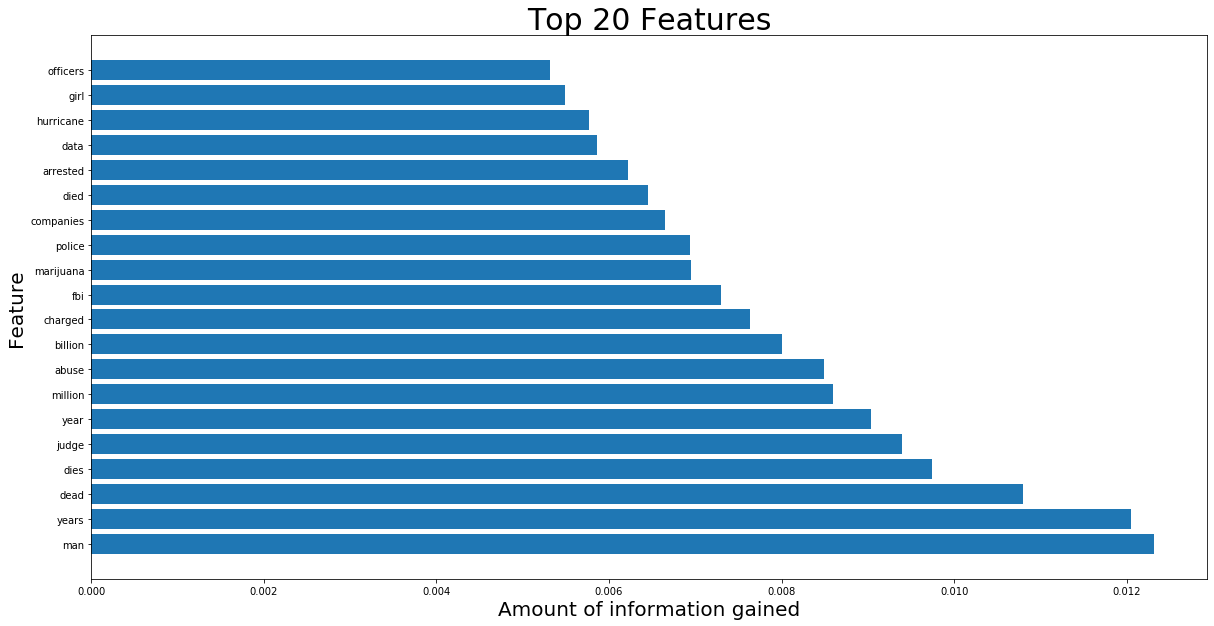

In [25]:
plt.figure(figsize=(20,10))
temp = feat_importance.sort_values('importance', ascending=False).head(20)
plt.barh(temp.index, temp['importance'])
plt.title('Top 20 Features', fontsize=30)
plt.xlabel('Amount of information gained', fontsize=20)
plt.ylabel('Feature', fontsize=20)

In [26]:
svc = SVC(gamma='scale')

In [27]:
pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('svc', SVC()),
])

In [28]:
parameters = {
     'vect__ngram_range': [(1, 1), (1, 2)],
 }

In [32]:
gs = GridSearchCV(svc, parameters, cv=5, n_jobs=-1)

In [33]:
gs.fit(X_train, y_train)
gs.score(y_train, y_train)

ValueError: Invalid parameter vect for estimator SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False). Check the list of available parameters with `estimator.get_params().keys()`.

In [ ]:
gs.score(test_df, y_test)

In [ ]:
svc = SVC(kernel='linear', gamma='scale')
svc.fit(train_df, y_train)

svc.score(train_df, y_train)

In [ ]:
svc.score(test_df, y_test)

In [ ]:
feat_importance = pd.DataFrame(np.transpose(svc.coef_), train_df.columns, columns=['importance'])

In [ ]:
feat_importance.sort_values(by='importance', ascending=False).head(20)

In [ ]:
feat_importance.sort_values(by='importance', ascending=False).tail(20)

In [ ]:
mnb = MultinomialNB()

mnb.fit(train_df, y_train)

mnb.score(train_df, y_train)

In [ ]:
mnb.score(test_df, y_test)

In [ ]:
mnb.coef_

In [ ]:
type(mnb.coef_)

In [ ]:
feat_importance = pd.DataFrame(np.transpose(mnb.coef_), train_df.columns, columns=['importance'])

In [ ]:
feat_importance.sort_values(by='importance', ascending=True).head(20)

In [ ]:
feat_importance.sort_values(by='importance', ascending=True).tail(20)

In [ ]:
from wordcloud import WordCloud, STOPWORDS

In [ ]:

stopwords = set(STOPWORDS)
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=24 
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [ ]:
show_wordcloud(reddit[reddit['is_news'] == 1])

In [ ]:
show_wordcloud(reddit[reddit['is_news'] == 0])

In [ ]:
reddit[reddit['is_news'] == 1]